# U.S. Medical Insurance Costs

Tasks:
1. read in insurance.csv
2. check that it's looking ok (no missing data/weirdness)
3. do stuff

## load up the packages (some prob uneccessary)
!python -m pip install statsmodels 


In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy import stats
from matplotlib import pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from patsy import dmatrices
from collections import OrderedDict
import itertools
%matplotlib inline
# %load_ext rpy2.ipython
# %R library(lme4)


In [2]:
# read in data frame
df = pd.read_csv('insurance.csv')
df.head()
# df.shape

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


Create y (response) and x (predictor) data frames. General plan is to make a series of regressions to figure out which factors contribute most to insurance costs. 

First, go through singly to see how it looks. 


In [3]:
y, X = dmatrices('charges ~ age + sex + bmi + children + smoker + region', data=df, return_type='dataframe') # separate dependent and independent 
# y[:3].head() # response variable # if you want to doublecheck it's the right stuff
# X[:3].head() #predictor variables

## Fit Ordinary Least Square model and examine results. 

In [4]:
mod = sm.OLS(y, X) # ordinary least squares 
res = mod.fit() # get residuals
print(res.summary())   

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.751
Model:                            OLS   Adj. R-squared:                  0.749
Method:                 Least Squares   F-statistic:                     500.8
Date:                Sun, 18 Apr 2021   Prob (F-statistic):               0.00
Time:                        21:21:34   Log-Likelihood:                -13548.
No. Observations:                1338   AIC:                         2.711e+04
Df Residuals:                    1329   BIC:                         2.716e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept           -1.194e+04    

In [5]:
res.params # coeficients?


Intercept             -11938.538576
sex[T.male]             -131.314359
smoker[T.yes]          23848.534542
region[T.northwest]     -352.963899
region[T.southeast]    -1035.022049
region[T.southwest]     -960.050991
age                      256.856353
bmi                      339.193454
children                 475.500545
dtype: float64

In [6]:
res.rsquared # overall prediction ability

0.7509130345985207

Diagnostics on the model. First value is _F_ second value is _P value_ 

What does thisreally say though. Overall, the model isinformative-ish?


In [7]:
sm.stats.linear_rainbow(res)


(1.1295219863220352, 0.058405337687256226)

Below is some analysis of the model assumptions stolen from link below. The first code fails. Not sure what's up there. 

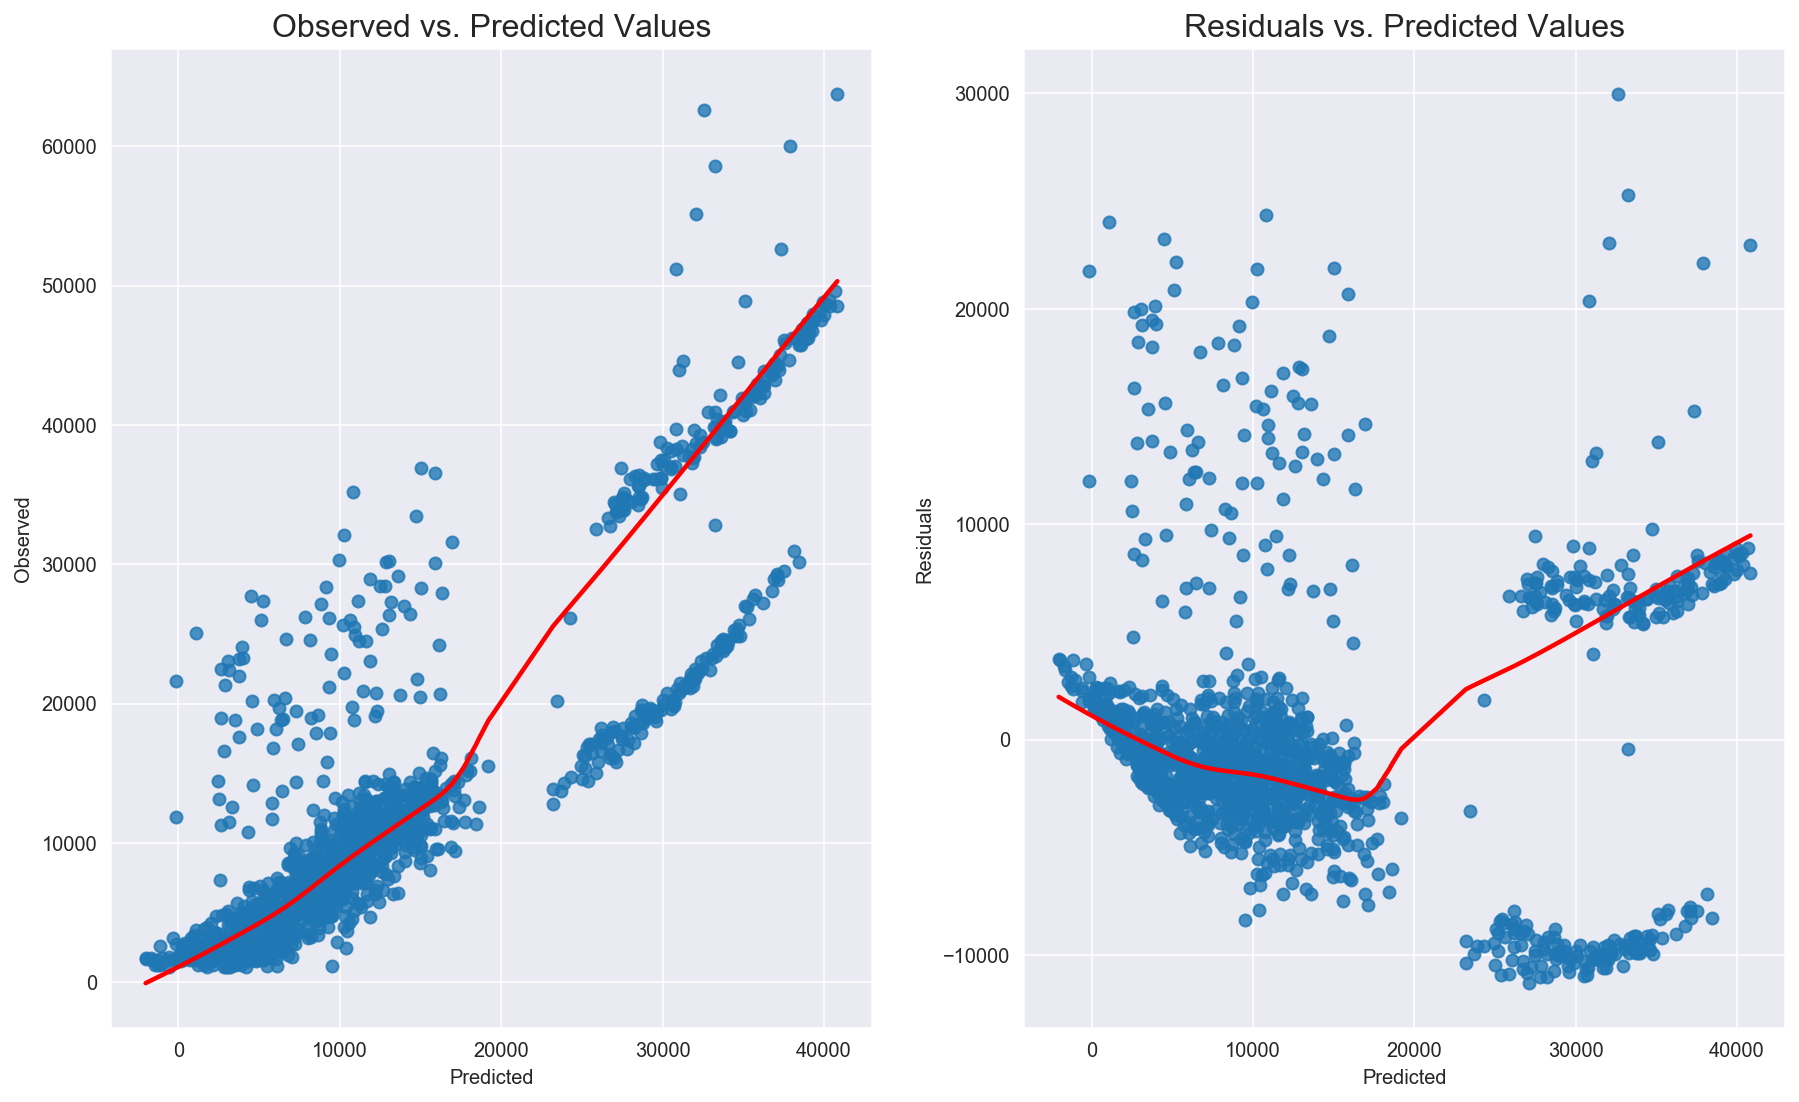

In [8]:
%config InlineBackend.figure_format ='retina'
import seaborn as sns 
import matplotlib.pyplot as plt
import statsmodels.stats.api as sms
sns.set_style('darkgrid')
sns.mpl.rcParams['figure.figsize'] = (15.0, 9.0)

# from https://towardsdatascience.com/verifying-the-assumptions-of-linear-regression-in-python-and-r-f4cd2907d4c0

def linearity_test(model, y):
    '''
    Function for visually inspecting the assumption of linearity in a linear regression model.
    It plots observed vs. predicted values and residuals vs. predicted values.
    
    Args:
    * model - fitted OLS model from statsmodels
    * y - observed values
    '''
    fitted_vals = model.predict()
    resids = model.resid

    fig, ax = plt.subplots(1,2)
    
    sns.regplot(x=fitted_vals, y=y, lowess=True, ax=ax[0], line_kws={'color': 'red'})
    ax[0].set_title('Observed vs. Predicted Values', fontsize=16)
    ax[0].set(xlabel='Predicted', ylabel='Observed')

    sns.regplot(x=fitted_vals, y=resids, lowess=True, ax=ax[1], line_kws={'color': 'red'})
    ax[1].set_title('Residuals vs. Predicted Values', fontsize=16)
    ax[1].set(xlabel='Predicted', ylabel='Residuals')
    
linearity_test(res, y)    


In [9]:
res.resid.mean()


-6.878988327310937e-12

Checking homoscedasticity ofvariance


 Breusch-Pagan test ----
                                      value
Lagrange multiplier statistic  1.217436e+02
p-value                        1.446718e-22
f-value                        1.662861e+01
f p-value                      1.145606e-23

 Goldfeld-Quandt test ----
                value
F statistic  0.956438
p-value      0.716299

 Residuals plots ----


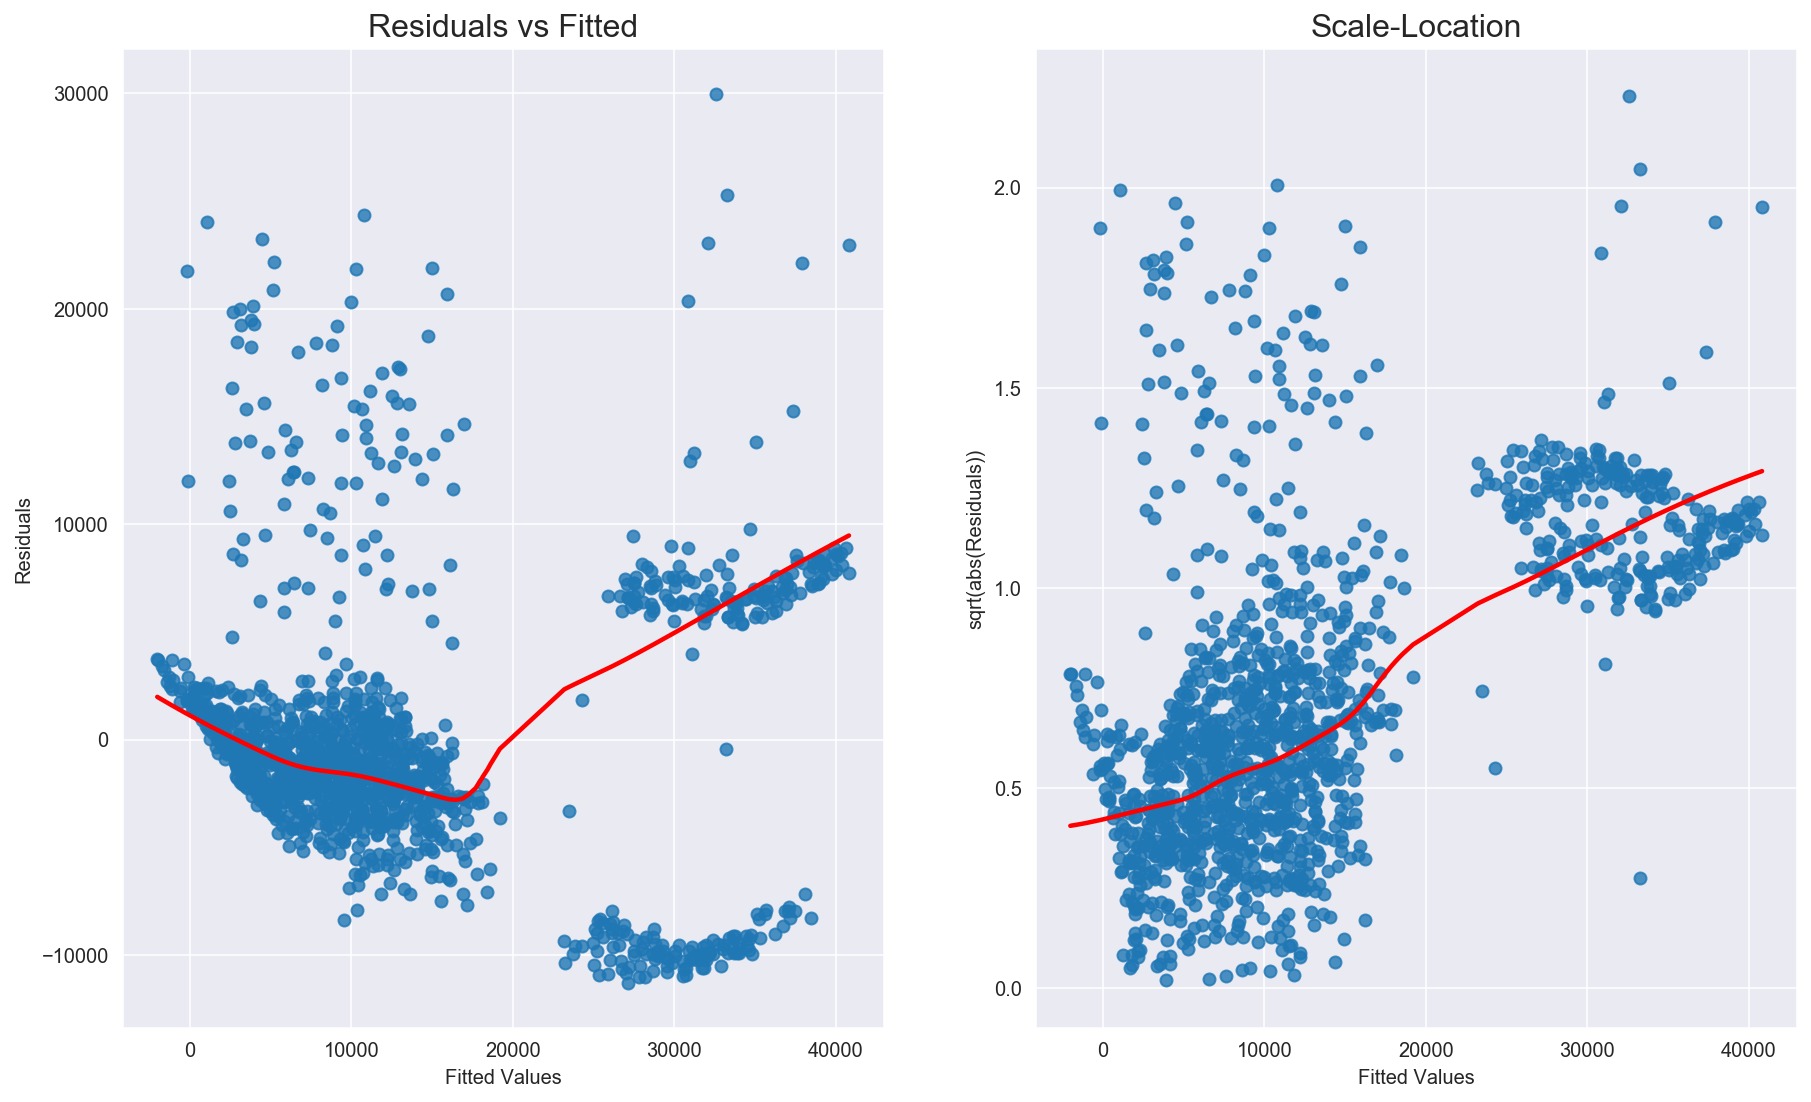

In [10]:
%matplotlib inline
%config InlineBackend.figure_format ='retina'
import seaborn as sns 
import matplotlib.pyplot as plt
import statsmodels.stats.api as sms
sns.set_style('darkgrid')
sns.mpl.rcParams['figure.figsize'] = (15.0, 9.0)

def homoscedasticity_test(model):
    '''
    Function for testing the homoscedasticity of residuals in a linear regression model.
    It plots residuals and standardized residuals vs. fitted values and runs Breusch-Pagan and Goldfeld-Quandt tests.
    
    Args:
    * model - fitted OLS model from statsmodels
    '''
    fitted_vals = model.predict()
    resids = model.resid
    resids_standardized = model.get_influence().resid_studentized_internal

    fig, ax = plt.subplots(1,2)

    sns.regplot(x=fitted_vals, y=resids, lowess=True, ax=ax[0], line_kws={'color': 'red'})
    ax[0].set_title('Residuals vs Fitted', fontsize=16)
    ax[0].set(xlabel='Fitted Values', ylabel='Residuals')

    sns.regplot(x=fitted_vals, y=np.sqrt(np.abs(resids_standardized)), lowess=True, ax=ax[1], line_kws={'color': 'red'})
    ax[1].set_title('Scale-Location', fontsize=16)
    ax[1].set(xlabel='Fitted Values', ylabel='sqrt(abs(Residuals))')

    bp_test = pd.DataFrame(sms.het_breuschpagan(resids, model.model.exog), 
                           columns=['value'],
                           index=['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value'])

    gq_test = pd.DataFrame(sms.het_goldfeldquandt(resids, model.model.exog)[:-1],
                           columns=['value'],
                           index=['F statistic', 'p-value'])

    print('\n Breusch-Pagan test ----')
    print(bp_test)
    print('\n Goldfeld-Quandt test ----')
    print(gq_test)
    print('\n Residuals plots ----')

homoscedasticity_test(res)


Above appears to violate assumptions of linearity, log transform?


Redo model with log transformed y

In [11]:
mod2 = sm.OLS(np.log(y), X)
res2 = mod2.fit()
# print(res2.summary())   

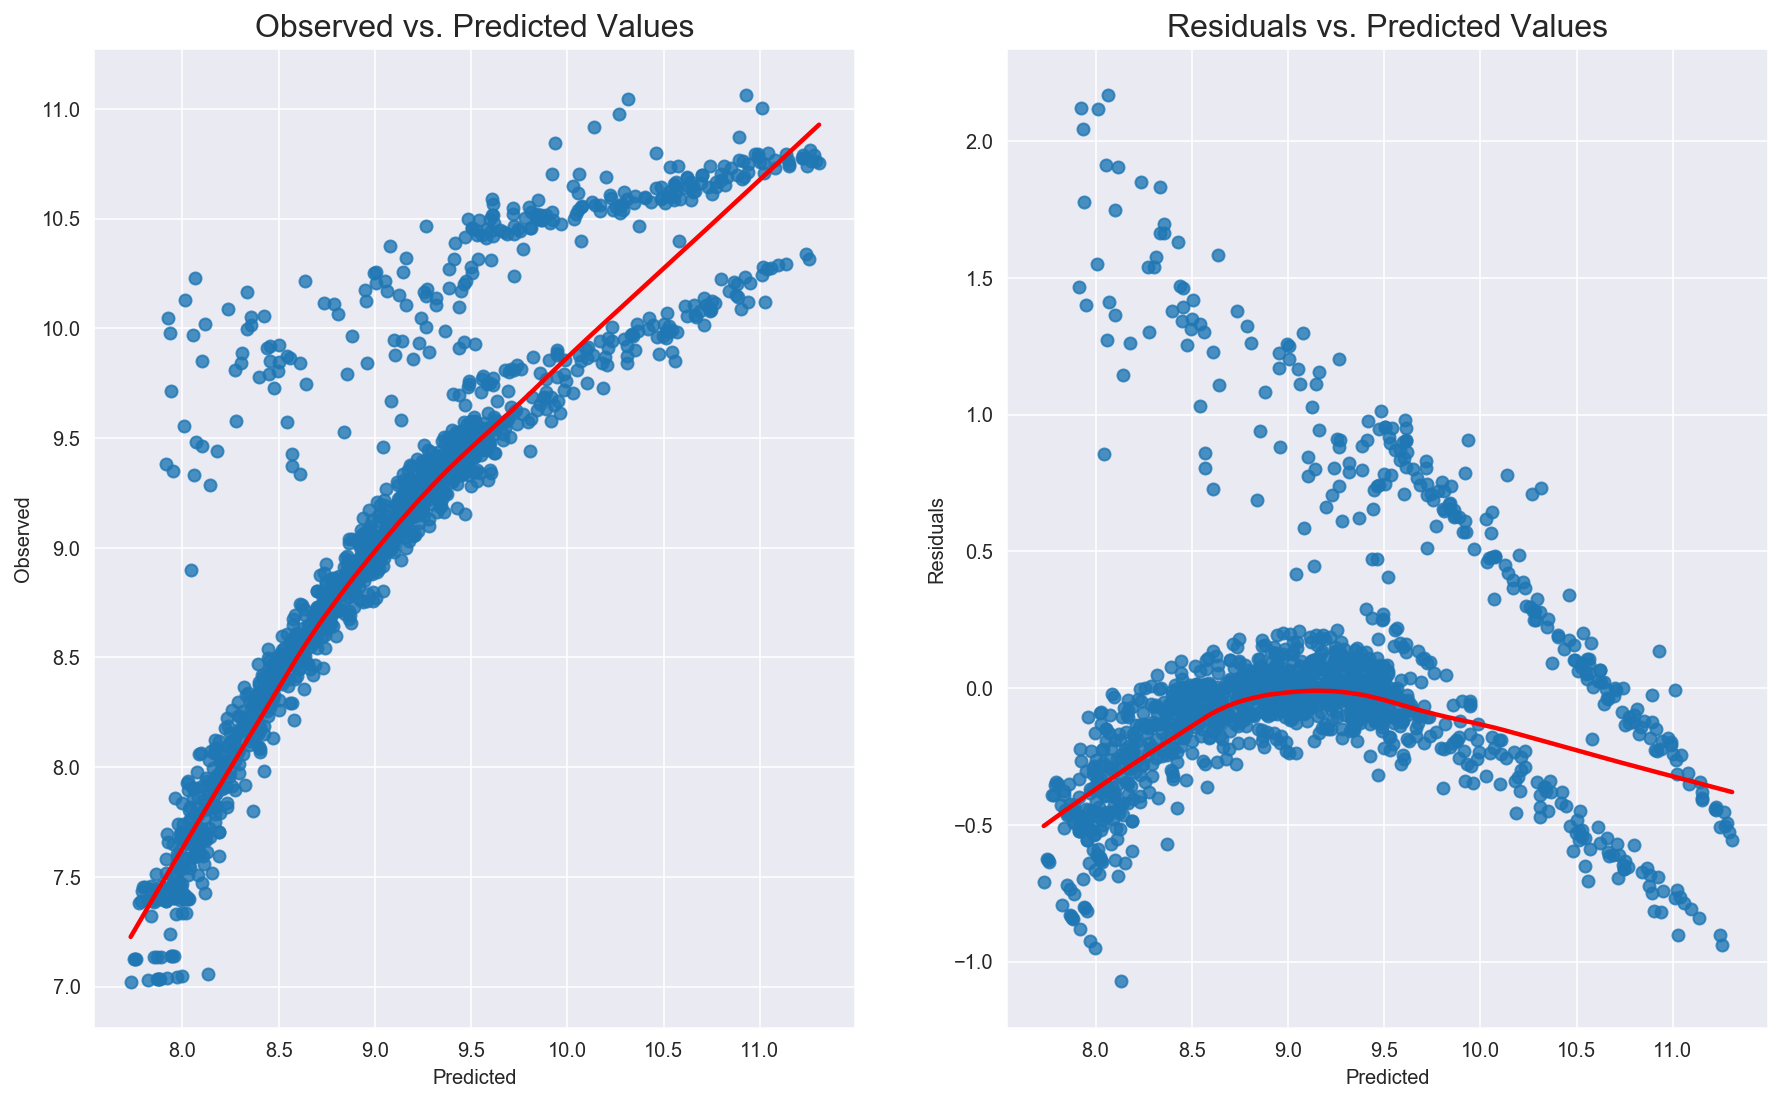

In [12]:
linearity_test(res2, np.log(y))    



 Breusch-Pagan test ----
                                      value
Lagrange multiplier statistic  7.708083e+01
p-value                        1.887683e-13
f-value                        1.015533e+01
f p-value                      7.650759e-14

 Goldfeld-Quandt test ----
                value
F statistic  0.887465
p-value      0.937302

 Residuals plots ----


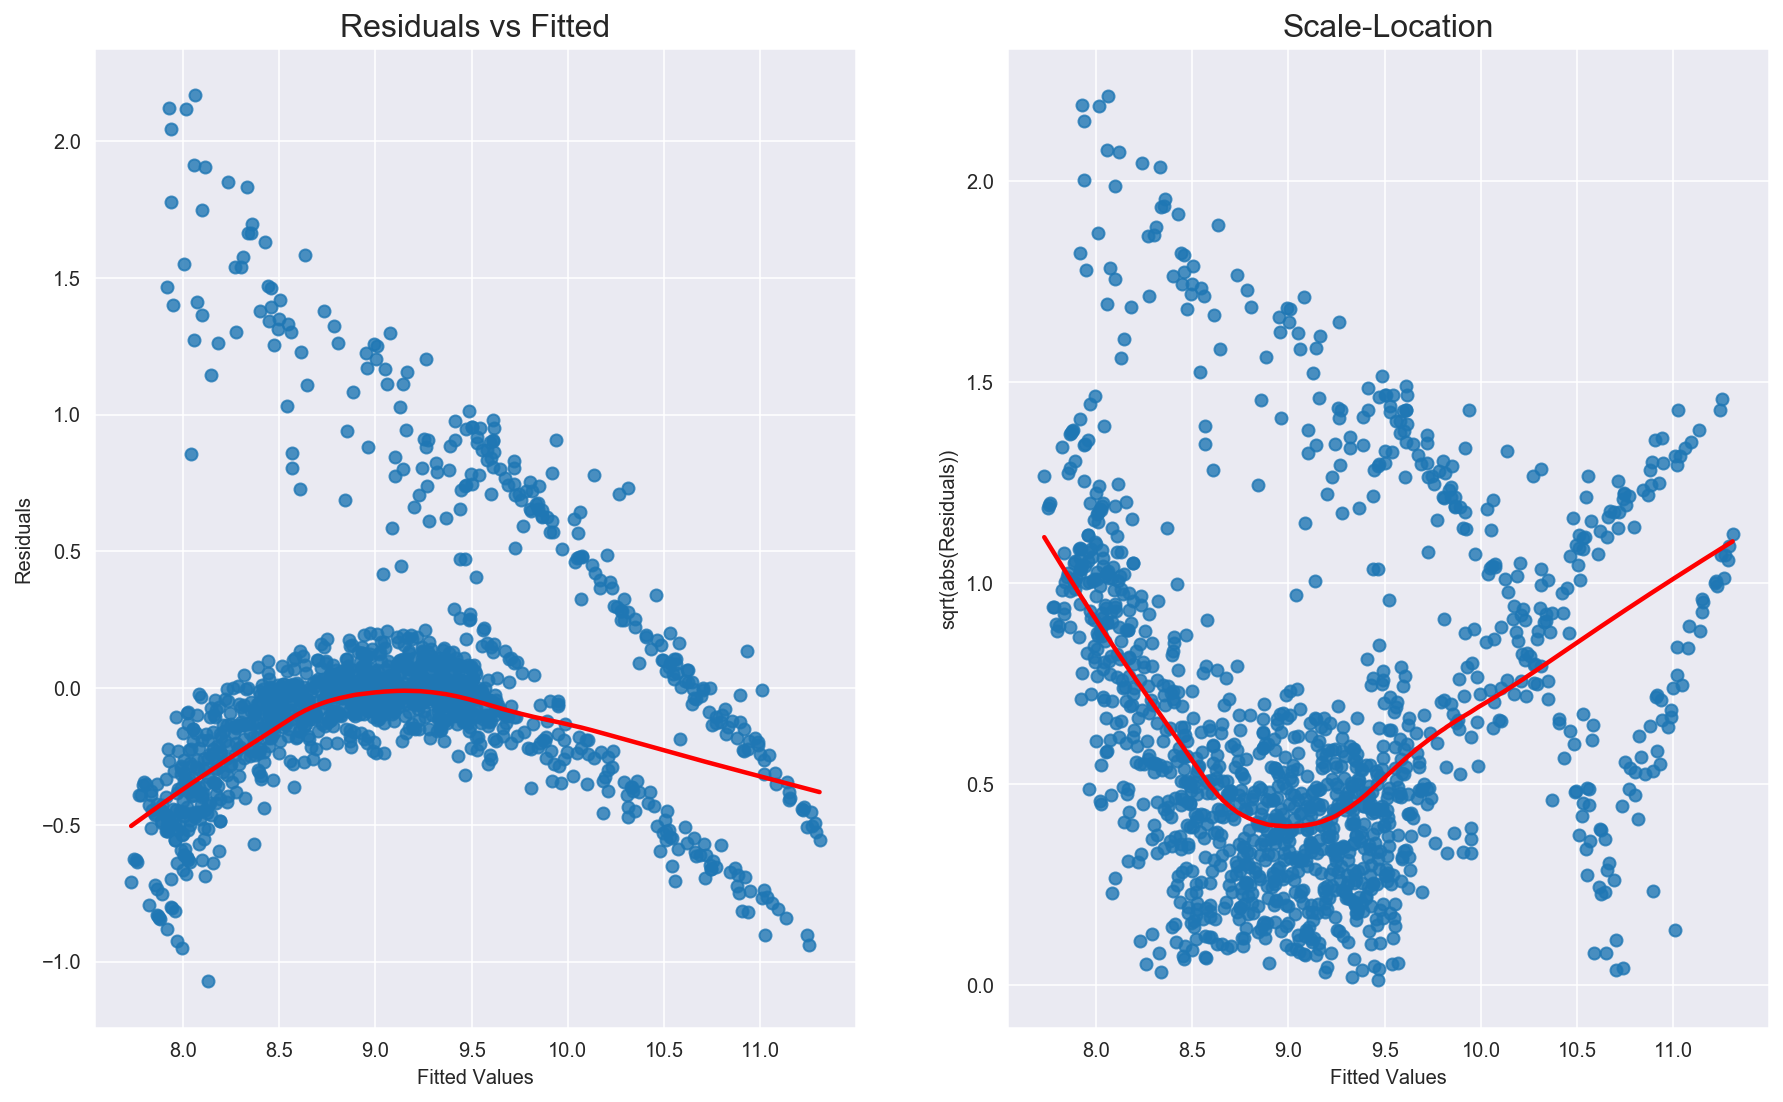

In [13]:
homoscedasticity_test(res2)


## The log transformed values appear better.

### Checking for autocorrelation. Looks ok. 
 

In [14]:
# import statsmodels.tsa.api as smt

# acf = smt.graphics.plot_acf(res.resid, lags=40 , alpha=0.05)
# acf.show()


C:\Users\Seth\Anaconda3\envs\myenv\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  after removing the cwd from sys.path.


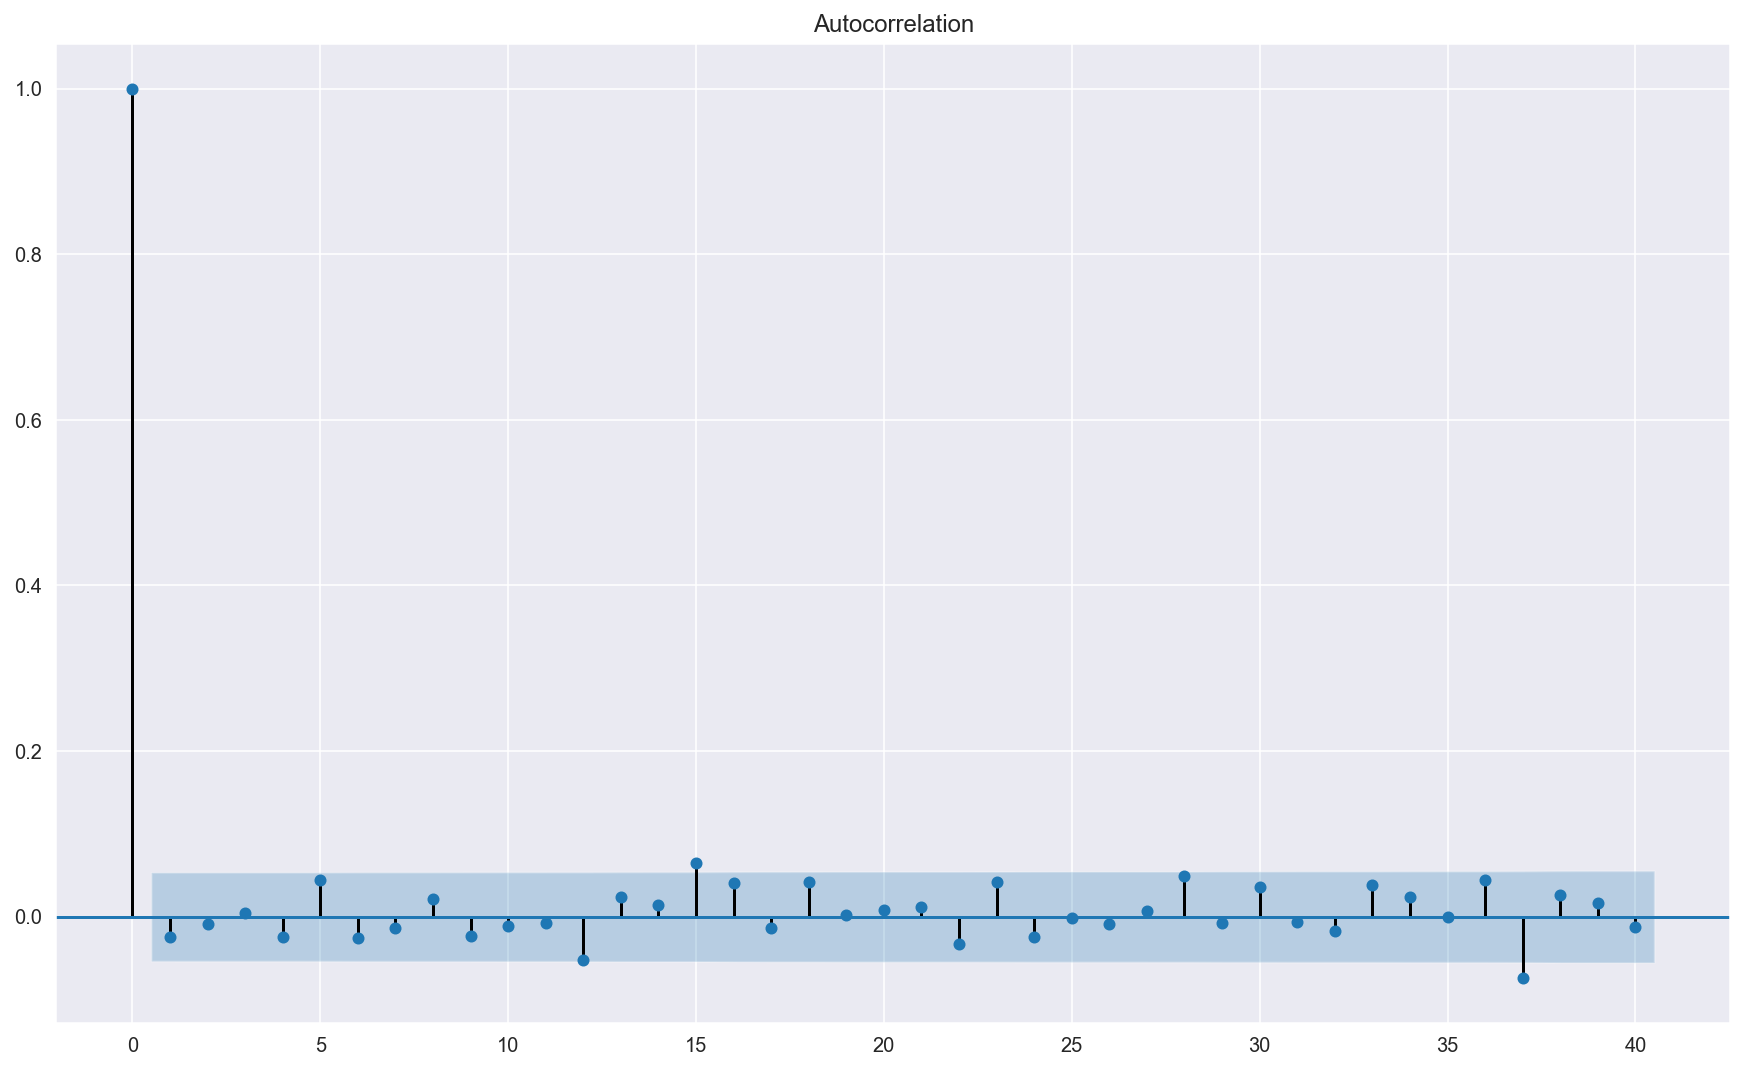

In [15]:
import statsmodels.tsa.api as smt

acf = smt.graphics.plot_acf(res2.resid, lags=40 , alpha=0.05)
acf.show()


Check normality of residuals. Again lifted from internets. 

Jarque-Bera test ---- statistic: 718.8873, p-value: 0.0
Shapiro-Wilk test ---- statistic: 0.8989, p-value: 0.0000
Kolmogorov-Smirnov test ---- statistic: 0.6263, p-value: 0.0000
Anderson-Darling test ---- statistic: 44.8640, 5% critical value: 0.7850
If the returned AD statistic is larger than the critical value, then for the 5% significance level, the null hypothesis that the data come from the Normal distribution should be rejected. 


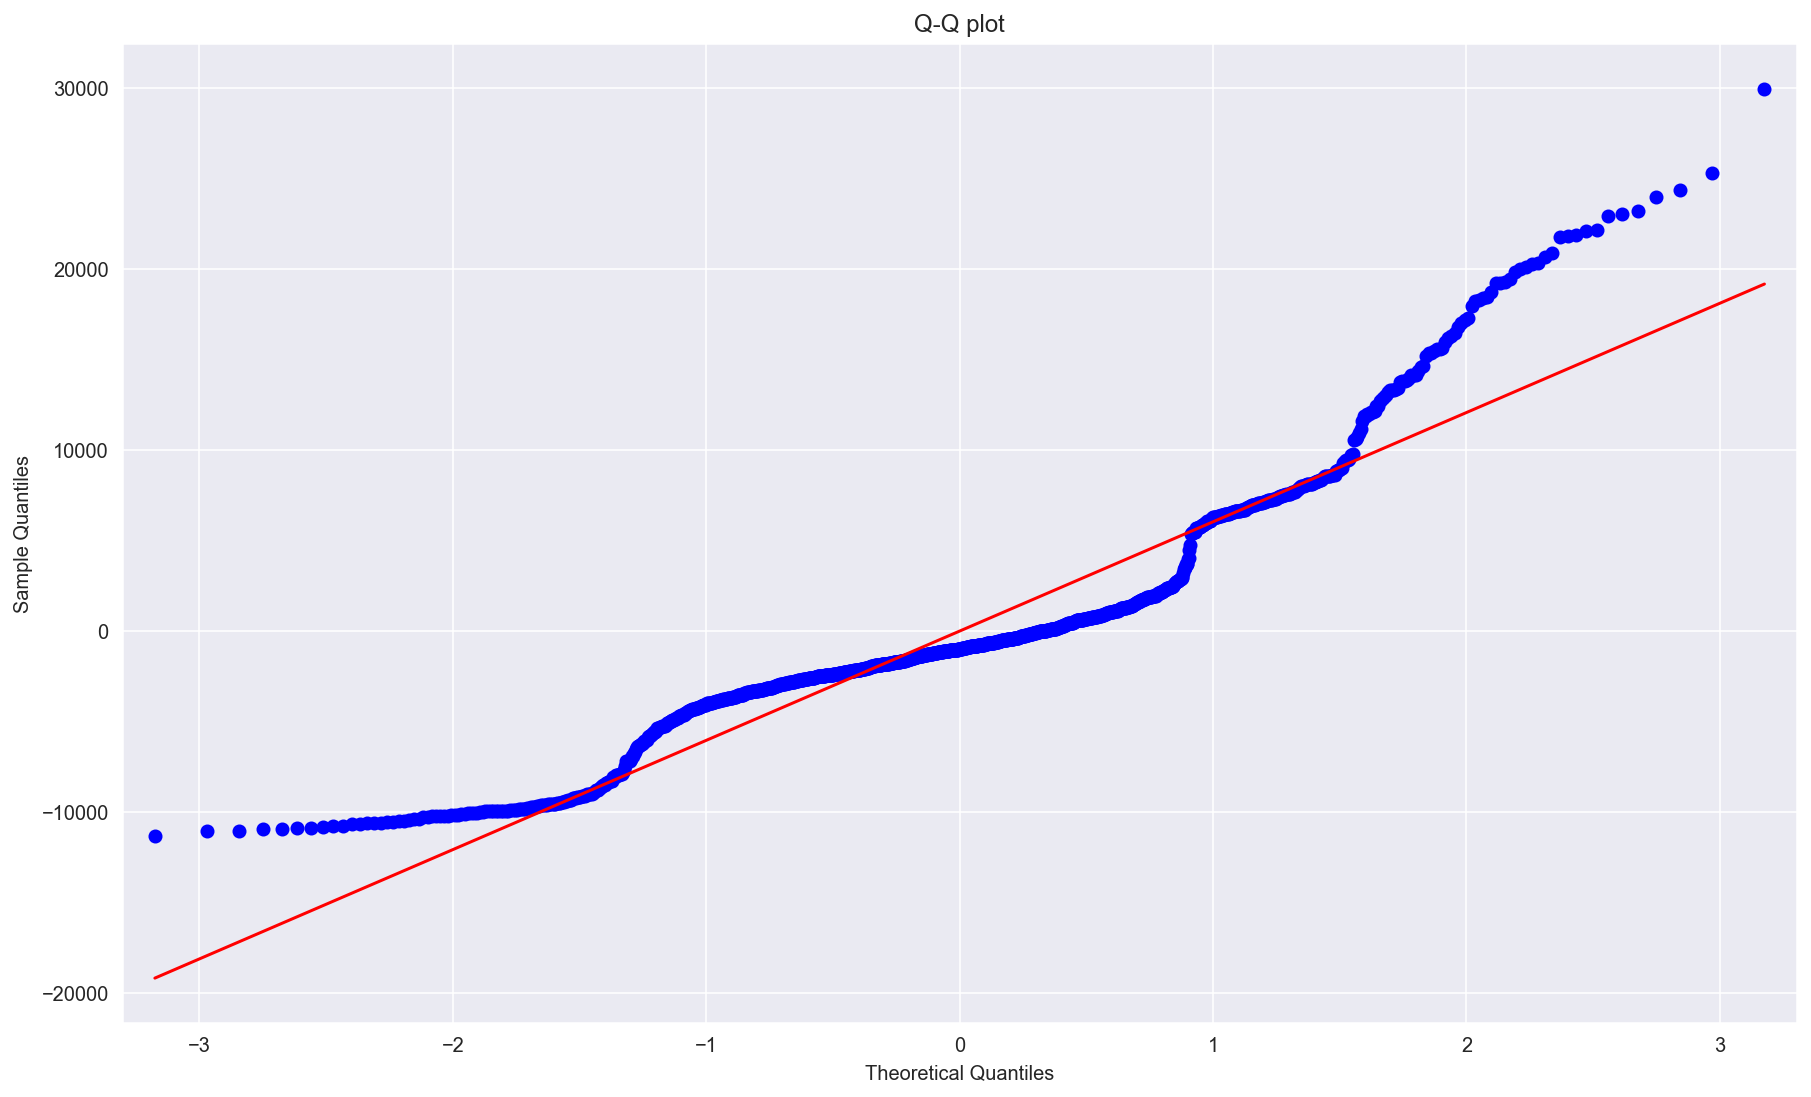

In [16]:
from scipy import stats

def normality_of_residuals_test(model):
    '''
    Function for drawing the normal QQ-plot of the residuals and running 4 statistical tests to 
    investigate the normality of residuals.
    
    Arg:
    * model - fitted OLS models from statsmodels
    '''
    sm.ProbPlot(model.resid).qqplot(line='s');
    plt.title('Q-Q plot');

    jb = stats.jarque_bera(model.resid)
    sw = stats.shapiro(model.resid)
    ad = stats.anderson(model.resid, dist='norm')
    ks = stats.kstest(model.resid, 'norm')
    
    print(f'Jarque-Bera test ---- statistic: {jb[0]:.4f}, p-value: {jb[1]}')
    print(f'Shapiro-Wilk test ---- statistic: {sw[0]:.4f}, p-value: {sw[1]:.4f}')
    print(f'Kolmogorov-Smirnov test ---- statistic: {ks.statistic:.4f}, p-value: {ks.pvalue:.4f}')
    print(f'Anderson-Darling test ---- statistic: {ad.statistic:.4f}, 5% critical value: {ad.critical_values[2]:.4f}')
    print('If the returned AD statistic is larger than the critical value, then for the 5% significance level, the null hypothesis that the data come from the Normal distribution should be rejected. ')
    
normality_of_residuals_test(res)


Jarque-Bera test ---- statistic: 1673.7604, p-value: 0.0
Shapiro-Wilk test ---- statistic: 0.8373, p-value: 0.0000
Kolmogorov-Smirnov test ---- statistic: 0.2831, p-value: 0.0000
Anderson-Darling test ---- statistic: 74.8074, 5% critical value: 0.7850
If the returned AD statistic is larger than the critical value, then for the 5% significance level, the null hypothesis that the data come from the Normal distribution should be rejected. 


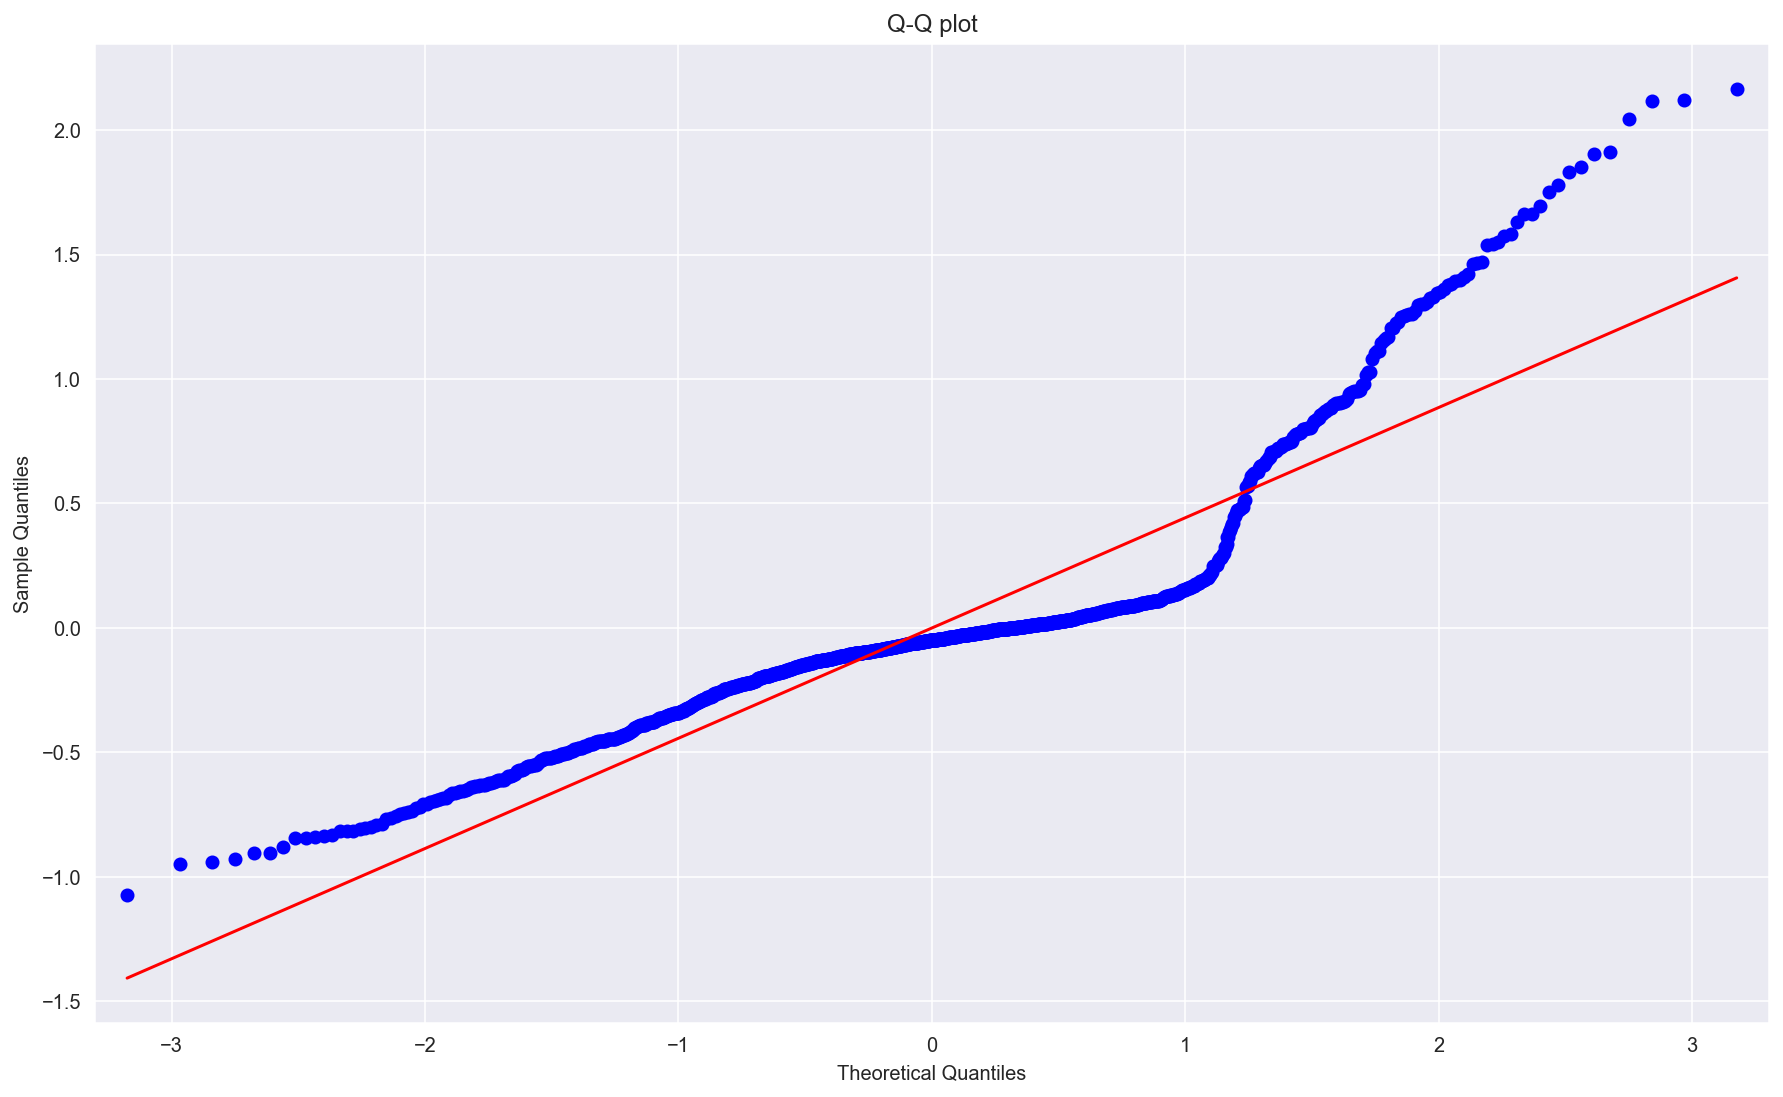

In [17]:
normality_of_residuals_test(res2)


## Above aren't particularly normal, so use boxcox transformations to improve normality of input data

(array([ 46., 105., 101., 155., 198., 283., 156., 123., 115.,  56.]),
 array([ 7.02275569,  7.42678461,  7.83081352,  8.23484244,  8.63887136,
         9.04290027,  9.44692919,  9.8509581 , 10.25498702, 10.65901594,
        11.06304485]),
 <a list of 10 Patch objects>)

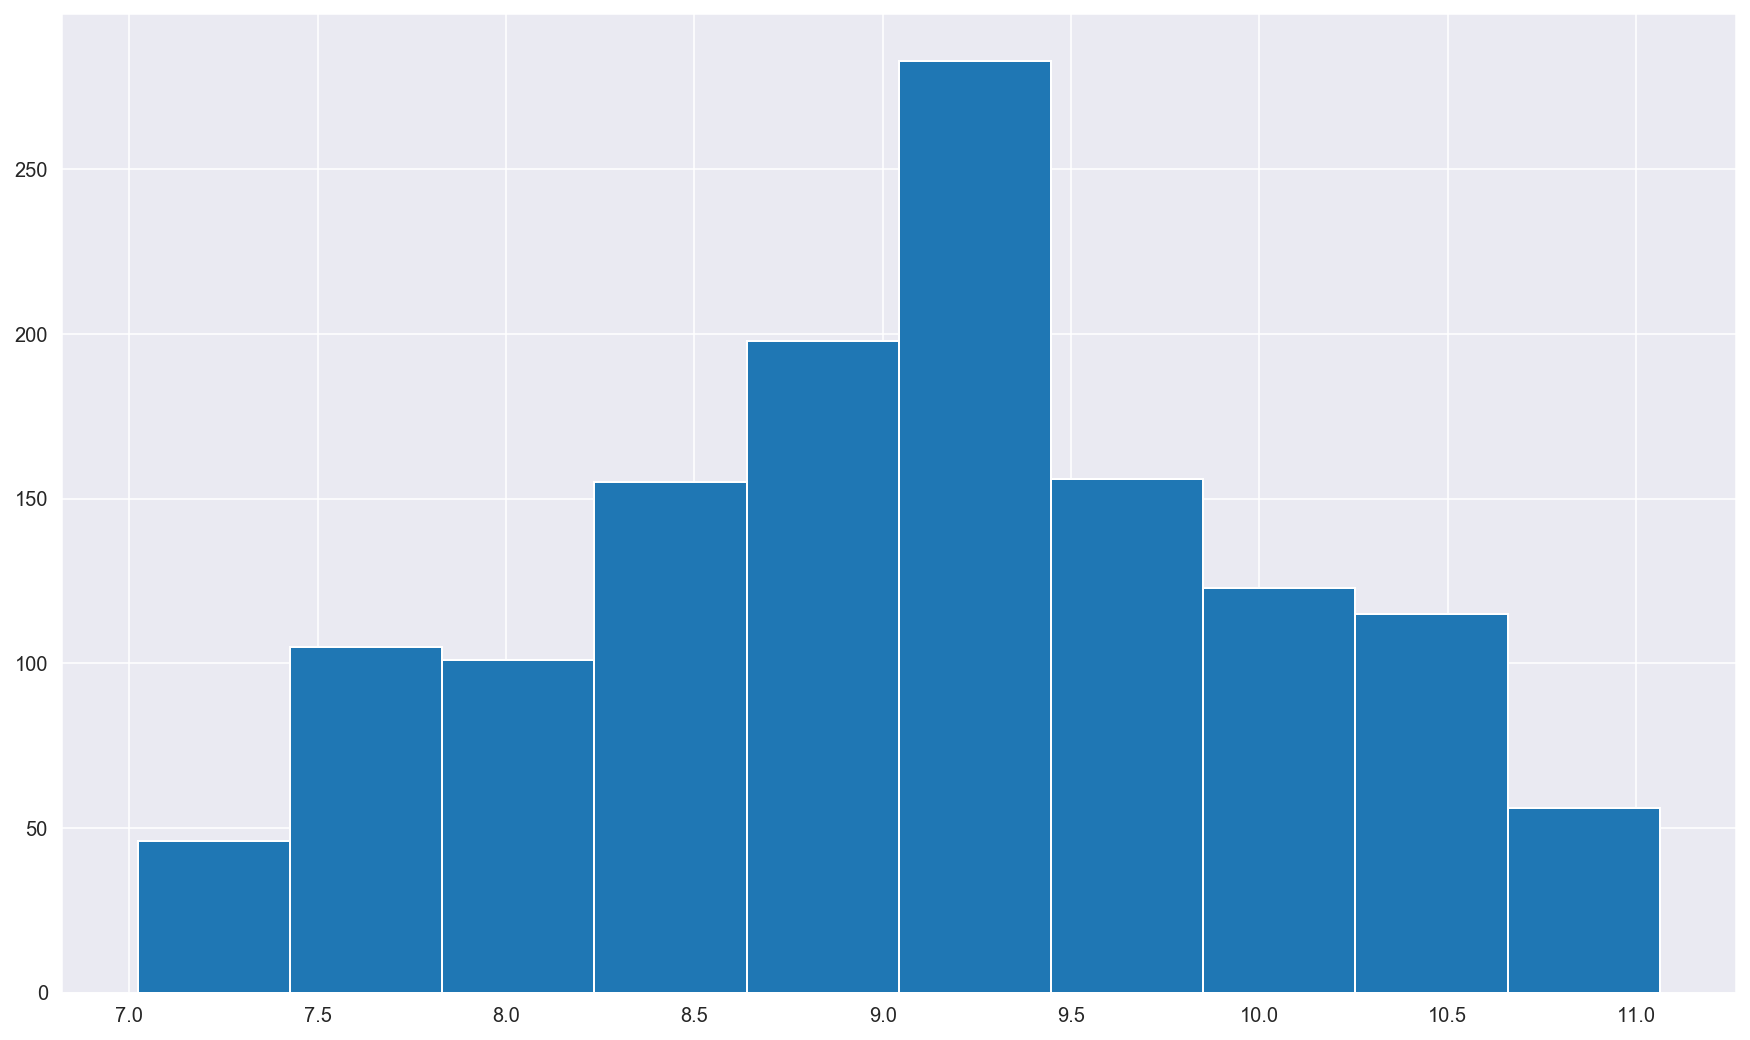

In [18]:
from scipy.stats import boxcox

n_y = boxcox(df.charges, 0) # new boxcox transformed y

plt.hist(n_y)
# plt.hist(y)

Much more normal looking!

## Now, let's see what contributes to overall costs using model selection based on AIC/BIC from the model.  

# Plan:

- [x] iterate and produce all possible model designs. 
- [x] run each model
- [x] return a list containing each model
- [x] return a list of the aic of each model
- [x] sort according to aic (smallest to largest)
- [x] return with table describing difference to next model with best model first. Better than 2 or go with simpler

In [45]:
# all x factors
xlist = ['age', 'sex', 'bmi', 'children', 'smoker', 'region']

# 1. take all x terms and combines.
def iterateXs(list_of_xs):
    allcomb=[]
    for i in range(1, len(list_of_xs)):
        allcomb.append(list(itertools.combinations(list_of_xs, i))) # combine all versions
    print(f'Produced {len(allcomb):.0f} levels of models from the input: {list_of_xs}.')
    return allcomb

# take above output lisst and make a list of all models
def buildMods(your_y, your_model_combinations):
    """
    For producing models including a designated string of your response variable 'Y'
    """
    allmods = []
    for level in your_model_combinations:
        for mod in level:
            if len(mod)==1:
                thismod=your_y+'~'+"".join(list(mod))
                allmods.append(thismod)
                # print(thismod)
            elif len(mod) > 1:
                thismod = your_y+'~'+"+".join(list(mod)) #'charges~'+
                allmods.append(thismod)
    print(f'Produced {len(allmods):.0f} models.')
    return allmods

# realized we need to set the y each time so just get the x's
def buildMods_noY(your_model_combinations):
    """
    Produce all possible models without explicitly including Y response variable. 
    """
    allmods = []
    for level in your_model_combinations:
        for mod in level:
            if len(mod)==1:
                thismod="".join(list(mod))
                allmods.append(thismod)
                # print(thismod)
            elif len(mod) > 1:
                thismod = "+".join(list(mod)) #'charges~'+
                allmods.append(thismod)
    print(f'Produced {len(allmods):.0f} models.')
    print()
    return allmods



In [24]:
# # y, X = dmatrices('charges ~ age + sex + bmi + children + smoker + region', data=df, return_type='dataframe') # separate dependent and independent 


# xlist = ['age', 'sex', 'bmi', 'children', 'smoker', 'region']

# # Make a list of all possible combinations of the x's
# allcomb =[]
# for i in range(1, len(xlist)):
#     allcomb.append(list(itertools.combinations(xlist, i))) # combine all versions

# # print(allcomb) # all possible models
# print(len(allcomb))

# # print((allcomb))
# # list(itertools.combinations(xlist, ))

5


In [25]:

# # format so we see the model
# allmods = []
# for level in allcomb:
#     for mod in level:
#         if len(mod)==1:
#             thismod='charges~'+"".join(list(mod))
#             allmods.append(thismod)
#             # print(thismod)
#         if len(mod) > 1:
#             thismod = 'charges~'+"+".join(list(mod)) #'charges~'+
#             allmods.append(thismod)
#             # print(thismod)
#         # print(level)
#         # print('\n'+mod+'\n')
    # y, X = dmatrices('charges ~ age + sex + bmi + children + smoker + region', data=df, return_type='dataframe') # separate dependent and independent 



In [46]:
# Check
testIt = iterateXs(xlist)
# print(testIt)
testMods = buildMods_noY(testIt) #'charges', 
# print(testMods)

Produced 5 levels of models from the input: ['age', 'sex', 'bmi', 'children', 'smoker', 'region'].
Produced 62 models.



Lambda value used for Transformation: 0.043649053770664956


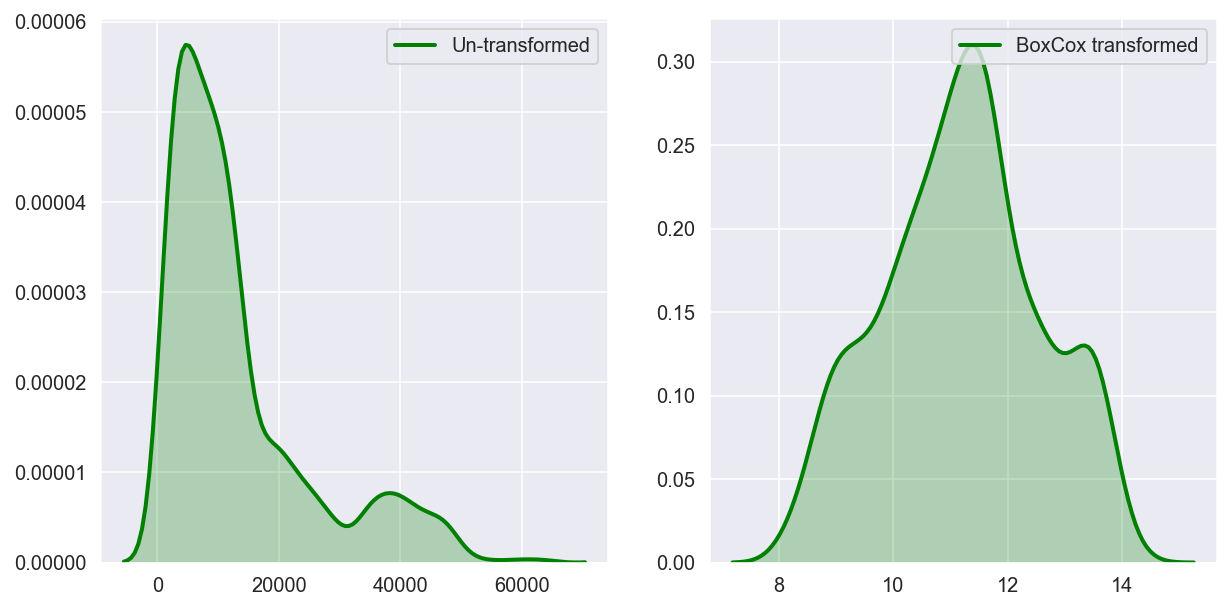

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2)
sns.distplot(y, hist = False, kde = True,
            kde_kws = {'shade': True, 'linewidth': 2}, 
            label = "Un-transformed", color ="green", ax = ax[0])

fitted_data, fitted_lambda = stats.boxcox(y.charges)

sns.distplot(fitted_data, hist = False, kde = True,
            kde_kws = {'shade': True, 'linewidth': 2}, 
            label = "BoxCox transformed", color ="green", ax = ax[1])

# adding legends to the subplots
plt.legend(loc = "upper right")
  
# rescaling the subplots
fig.set_figheight(5)
fig.set_figwidth(10)
  
print(f"Lambda value used for Transformation: {fitted_lambda}")

In [47]:
# print(testMods)
# to do: run the models. 
# make function that takes models and y identifier and transformation TRUE/F 

def runModels(yname, testMods, targetDF, sortby, transf):
    '''
    feed name of response variable, the model list, source df, and whether you need to boxcox transform the y 
    '''
    allOLS=[]
    allRes=[]
    allAIC=[]
    allBIC=[]
    allR=[]
    lambdas=[]
    outDF = pd.DataFrame()
    if transf==False:
        for mod in testMods:
            thisy, thisX = dmatrices(yname+'~'+mod, data=targetDF, return_type='dataframe')
            thisOLS=sm.OLS(thisy, thisX)
            thisRes=thisOLS.fit()
            thisAIC=thisRes.aic
            thisBIC=thisRes.bic
            thisR=thisRes.rsquared
            allRes.append(thisRes)
            allAIC.append(thisAIC)
            allBIC.append(thisBIC)
            allR.append(thisR)
        # outDF = pd.DataFrame()
        outDF['Model']=testMods
        outDF['Rsq']=allR
        outDF['AIC']=allAIC
        outDF['BIC']=allBIC
    else:
        fitted_data, fitted_lambda = stats.boxcox(targetDF[yname])
        # fitted_data, fitted_lambda = stats.boxcox(yname, data=targetDF)
        for mod in testMods:
            thisy, thisX = dmatrices(yname+'~'+mod, data=targetDF, return_type='dataframe')
            # fitted_data, fitted_lambda = stats.boxcox(targetDF[yname])
            thisOLS=sm.OLS(fitted_data, thisX)
            thisRes=thisOLS.fit()
            thisAIC=thisRes.aic
            thisBIC=thisRes.bic
            thisR=thisRes.rsquared
            allRes.append(thisRes)
            allAIC.append(thisAIC)
            allBIC.append(thisBIC)  
            lambdas.append(fitted_lambda)
            allR.append(thisR)
        # outDF = pd.DataFrame()
        outDF['Model']=testMods
        outDF['Rsq']=allR
        outDF['AIC']=allAIC
        outDF['BIC']=allBIC
        outDF['Lambda']=lambdas
    outDF= outDF.sort_values(by=[sortby]).reset_index() # return sorted by column of interest AIC, BIC, Rsq, model
    print(f"The best model based on {sortby} is {outDF['Model'][0]} with an {sortby} of {outDF[sortby][0]:.2f}.")
    return outDF



In [48]:
testall=runModels('charges', testMods,  df, 'AIC',True)

The best model based on AIC is age+bmi+children+smoker+region with an AIC of 2684.92.


In [35]:
# function to take df with AIC/BIC and compare each level to one worse and return difference (until last, which is null)

# here wanting to id when there is a 'real' change in IC value. Traditionally a change of 2 or more is considered notable. 
def getBigBest(sortedTab, whichIC): 
    '''
    Give a sorted table produced by getDeltaLambda function below and the IC metric you are interested in (AIC or BIC). Will look at teach delta-IC value and return the row from the sorted table that is the first >2 IC step. 
    '''
    for i in range(len(sortedTab[whichIC])):
        if abs(sortedTab.iloc[i, -1]) > 2:# get i'th row last column which has the delta value
            print(f"The model which has the largest step change in {whichIC} is {sortedTab['Model'][i]} with {whichIC} of {sortedTab[whichIC][i]:.2f}. \n The next best model is {sortedTab['Model'][i+1]} which is {sortedTab['d'+whichIC][i]:.4f} worse based on {whichIC}. \n")
            print(sortedTab.iloc[i, 2:])
            return sortedTab.iloc[i,2:]
            break # when get the first instance of a 2 IC step

def getDeltaLambda(ModelTable, whichIC): 
    '''
    Give a table of models produced by runModels, and which IC value you are using (AIC or BIC)
    This will sort the table according to the IC metric of your choice and calculate the difference between this IC value and next best model. 
    '''
    sortedTab = ModelTable.sort_values(by=[whichIC]).reset_index() # sort and reset index - messed up otherw
    dICs = []
    for i in range(len(sortedTab)): #  
        # print(i)
        if i != len(sortedTab)-1: # not the last line (range is less than len)
            # xi = int(i)-1 # range starts at 1 right?
            dIC = sortedTab[whichIC][i] - sortedTab[whichIC][i+1] # idea is to get IC for this item and get diffs
            dICs.append(dIC)
        else:
            # dIC = NULL
            dICs.append('none')
    sortedTab['d'+whichIC] = dICs
    print(f"The best model based on {whichIC} is {sortedTab['Model'][0]} with {whichIC} of {sortedTab[whichIC][0]:.2f}. \n The next best model is {sortedTab['Model'][1]} which is {sortedTab['d'+whichIC][0]:.4f} worse based on {whichIC}. \n")
    bigbest=getBigBest(sortedTab, whichIC)
    return sortedTab, bigbest




In [36]:
getdics, bestmod = getDeltaLambda(testall, 'BIC')
# print(getdics.head())
# bestmod


The best model based on BIC is age+sex+bmi+children+smoker with BIC of 2726.22. 
 The next best model is age+bmi+children+smoker+region which is -0.2945 worse based on BIC. 

The model which has the largest step change in BIC is age+bmi+children+smoker with BIC of 2727.55. 
 The next best model is age+children+smoker which is -23.7352 worse based on BIC. 

Model     age+bmi+children+smoker
Rsq                      0.765477
AIC                       2701.56
BIC                       2727.55
Lambda                  0.0436491
dBIC                     -23.7352
Name: 2, dtype: object


In [37]:
bestmod.Model # access the model that gave best IC score

'age+bmi+children+smoker'

In [38]:
# to do: rerun with best model
# plot effects of major effects 
    # cost over age [line]
    # cost over bmi [line]
    # cost over children [boxplot?]
    # cost smoker/non [boxplot]

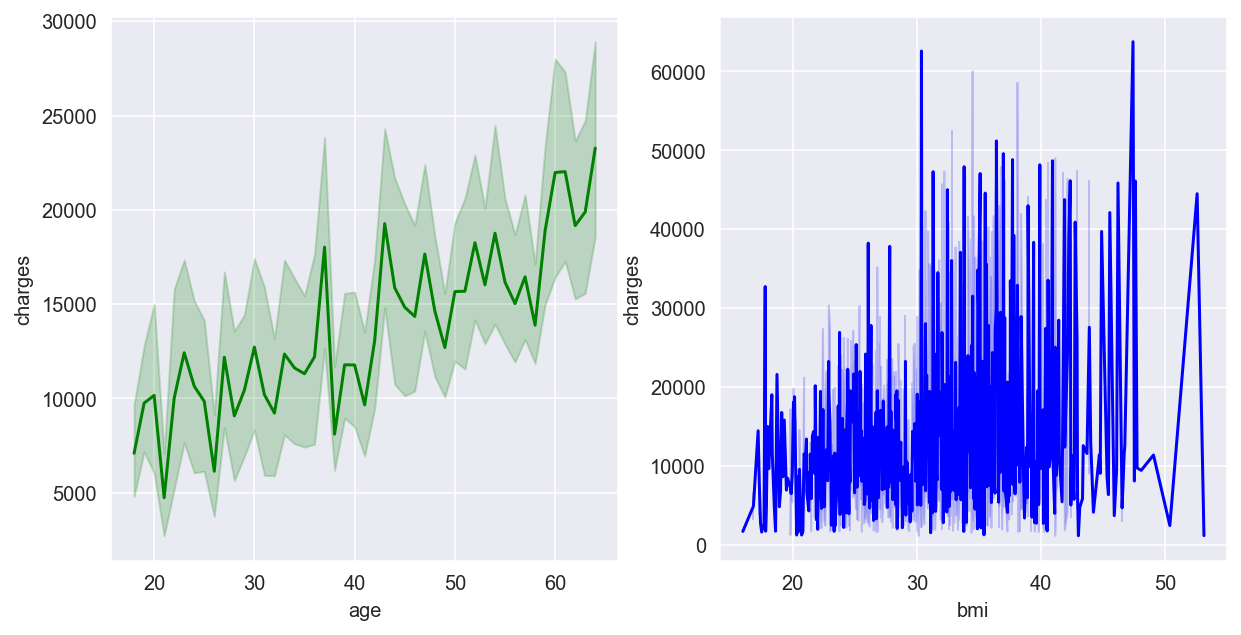

In [52]:
# import seaborn as sns
# import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2)

sns.lineplot(data = df, x = 'age', y = 'charges',
            color ="green", ax = ax[0])


sns.lineplot(data = df, x = 'bmi', y = 'charges',
            color ="blue", ax = ax[1])



# sns.distplot(y, hist = False, kde = True,
#             kde_kws = {'shade': True, 'linewidth': 2}, 
#             label = "Un-transformed", color ="green", ax = ax[0])

# fitted_data, fitted_lambda = stats.boxcox(y.charges)

# sns.distplot(fitted_data, hist = False, kde = True,
#             kde_kws = {'shade': True, 'linewidth': 2}, 
#             label = "BoxCox transformed", color ="green", ax = ax[1])

# # adding legends to the subplots
# plt.legend(loc = "upper right")
  
# rescaling the subplots
fig.set_figheight(5)
fig.set_figwidth(10)
  
# print(f"Lambda value used for Transformation: {fitted_lambda}")